In [2]:
import evaluate

In [5]:
#!pip install evaluate

In [3]:
metric = evaluate.load("mean_iou")

In [6]:
from scipy.io import loadmat
import numpy as np
from transformers import SamProcessor, SamModel
from datasets import Dataset, Image
import albumentations
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader as TorchDataset
from torch.optim import Adam
import monai
from tqdm import tqdm
from statistics import mean
import torch
from PIL import Image as PILImage

#TODO: Try other alternatives as base models
# alternatives: ["facebook/sam-vit-base", "facebook/sam-vit-huge", "facebook/sam-vit-large", "wanglab/medsam-vit-base"]
base_model_name = "facebook/sam-vit-base"
processor = SamProcessor.from_pretrained(base_model_name)
model = SamModel.from_pretrained(base_model_name)

def transform_image(img):
    img = img.transpose(2,1,0)
    image = np.expand_dims(img, axis=3)
    image = np.repeat(255 - image, 3, axis=3)
    return image

def get_valid_idx(mask):
    idx = []
    for i in range(0,61):
        temp = mask[:,:,i]
        if np.nansum(temp) != 0:
            idx.append(i)
    return idx

def create_dataset(images, labels):
    dataset = Dataset.from_dict({"image": images,
                                 "label": labels})
    dataset = dataset.cast_column("image", Image())
    dataset = dataset.cast_column("label", Image())

    return dataset

def transforms(examples):
    transformed_images, transformed_masks = [], []
    for image, seg_mask in zip(examples["image"], examples["label"]):
        image, seg_mask = np.array(image), np.array(seg_mask)
        transformed = transform(image=image, mask=seg_mask)
        transformed_images.append(transformed["image"])
        transformed_masks.append(transformed["mask"])
    examples["pixel_values"] = transformed_images
    examples["label"] = transformed_masks
    return examples

def visualize_seg_mask(image: np.ndarray, mask: np.ndarray):
    color_seg = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    color_seg[mask == 0, :] = [255,255,255]
    #color_seg[mask == 1, :] = [255,255,255]
    color_seg[mask == 1, :] = [255,0,0]
    color_seg = color_seg[..., ::-1]  # convert to BGR
    img = np.array(image) * 0.5 + color_seg * 0.5  # plot the image with the segmentation map
    img = img.astype(np.uint8)
    plt.figure(figsize=(15, 10))
    plt.imshow(img)
    plt.axis("off")
    plt.show()

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def get_bounding_box(ground_truth_map):
    # get bounding box from mask
    y_indices, x_indices = np.where(ground_truth_map > 0)
    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)
    # add perturbation to bounding box coordinates
    H, W = ground_truth_map.shape
    x_min = max(0, x_min - np.random.randint(0, 20))
    x_max = min(W, x_max + np.random.randint(0, 20))
    y_min = max(0, y_min - np.random.randint(0, 20))
    y_max = min(H, y_max + np.random.randint(0, 20))
    bbox = [x_min, y_min, x_max, y_max]

    return bbox

class SAMDataset(TorchDataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item["pixel_values"]
        ground_truth_mask = np.array(item["label"])
        # get bounding box prompt
        prompt = get_bounding_box(ground_truth_mask)
        # prepare image and prompt for the model
        inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")
        # remove batch dimension which the processor adds by default
        inputs = {k:v.squeeze(0) for k,v in inputs.items()}
        # add ground truth segmentation
        inputs["ground_truth_mask"] = ground_truth_mask
        return inputs

#make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
    if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
        param.requires_grad_(False)

mat_dme =[]
for i in range(10):
    number = str(i+1).zfill(2)
    mat_dme.append("..\data\Kaggle\Subject_"+number+".mat")


#TODO: Extend Code to multiple subjects
nr = 0
images = loadmat(mat_dme[nr])['images']
#TODO: Extend Code to manualFluid2
masks = loadmat(mat_dme[nr])['manualFluid1']
idx = get_valid_idx(masks)
masks = masks[:,:, idx]
images = images[:,:,idx]
images = transform_image(images)
#TODO: Extend Code to individual fluids (values 1,.. in the mask)
masks = np.where(masks == 0, 0, 1).transpose(2,1,0)
dataset = create_dataset(images=images, labels=masks)

#TODO: Explore Options for transformations
transform = albumentations.Compose([albumentations.Resize(256, 256),])
dataset.set_transform(transforms)

C:\Users\phili\anaconda3\envs\DILab\Lib\site-packages\datasets\features\image.py:332: UserWarning: Downcasting array dtype int32 to uint8 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")


In [7]:
base_model_name = "facebook/sam-vit-base"
processor = SamProcessor.from_pretrained(base_model_name)
model = SamModel.from_pretrained(base_model_name)

In [10]:
states = torch.load("../data/Kaggle/model_checkpoints/chkpt1.pt")

In [12]:
model.load_state_dict(states, strict=False)

_IncompatibleKeys(missing_keys=['shared_image_embedding.positional_embedding', 'vision_encoder.pos_embed', 'vision_encoder.patch_embed.projection.weight', 'vision_encoder.patch_embed.projection.bias', 'vision_encoder.layers.0.layer_norm1.weight', 'vision_encoder.layers.0.layer_norm1.bias', 'vision_encoder.layers.0.attn.rel_pos_h', 'vision_encoder.layers.0.attn.rel_pos_w', 'vision_encoder.layers.0.attn.qkv.weight', 'vision_encoder.layers.0.attn.qkv.bias', 'vision_encoder.layers.0.attn.proj.weight', 'vision_encoder.layers.0.attn.proj.bias', 'vision_encoder.layers.0.layer_norm2.weight', 'vision_encoder.layers.0.layer_norm2.bias', 'vision_encoder.layers.0.mlp.lin1.weight', 'vision_encoder.layers.0.mlp.lin1.bias', 'vision_encoder.layers.0.mlp.lin2.weight', 'vision_encoder.layers.0.mlp.lin2.bias', 'vision_encoder.layers.1.layer_norm1.weight', 'vision_encoder.layers.1.layer_norm1.bias', 'vision_encoder.layers.1.attn.rel_pos_h', 'vision_encoder.layers.1.attn.rel_pos_w', 'vision_encoder.layers.

In [21]:
model.load_state_dict(states, strict=False)
device = "cuda"
idx = 3
image = dataset[idx]["pixel_values"]
ground_truth_mask = np.array(dataset[idx]["label"])
prompt = get_bounding_box(ground_truth_mask)
inputs = processor(image, input_boxes=[[prompt]], return_tensors="pt").to(device)
model.eval()
model.to(device)
model.eval()
with torch.no_grad():
    outputs = model(**inputs, multimask_output=False)
# apply sigmoid
finetune_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
finetune_seg_prob = finetune_seg_prob.cpu().numpy().squeeze()
finetune_seg = (finetune_seg_prob > 0.5).astype(np.uint8)

In [22]:
base_model_name = "facebook/sam-vit-base"
processor = SamProcessor.from_pretrained(base_model_name)
model = SamModel.from_pretrained(base_model_name)
device = "cuda"
idx = 3
image = dataset[idx]["pixel_values"]
ground_truth_mask = np.array(dataset[idx]["label"])
prompt = get_bounding_box(ground_truth_mask)
inputs = processor(image, input_boxes=[[prompt]], return_tensors="pt").to(device)
model.eval()
model.to(device)
model.eval()
with torch.no_grad():
    outputs = model(**inputs, multimask_output=False)
# apply sigmoid
sam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
sam_seg_prob = sam_seg_prob.cpu().numpy().squeeze()
sam_seg = (sam_seg_prob > 0.5).astype(np.uint8)

In [23]:
base_model_name = "wanglab/medsam-vit-base"
processor = SamProcessor.from_pretrained(base_model_name)
model = SamModel.from_pretrained(base_model_name)
device = "cuda"
idx = 3
image = dataset[idx]["pixel_values"]
ground_truth_mask = np.array(dataset[idx]["label"])
prompt = get_bounding_box(ground_truth_mask)
inputs = processor(image, input_boxes=[[prompt]], return_tensors="pt").to(device)
model.eval()
model.to(device)
model.eval()
with torch.no_grad():
    outputs = model(**inputs, multimask_output=False)
# apply sigmoid
sam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
sam_seg_prob = sam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (sam_seg_prob > 0.5).astype(np.uint8)

In [27]:
metric2 = metric.compute(
    predictions=[ sam_seg ],
    references=[ground_truth_mask],
    num_labels=2,
    ignore_index=255,
    reduce_labels=False,
)

In [28]:
metric1 = metric.compute(
    predictions=[finetune_seg],
    references=[ground_truth_mask],
    num_labels=2,
    ignore_index=255,
    reduce_labels=False,
)

In [29]:
metric3 = metric.compute(
    predictions=[ medsam_seg],
    references=[ ground_truth_mask],
    num_labels=2,
    ignore_index=255,
    reduce_labels=False,
)

In [30]:
metric1

{'mean_iou': 0.486114501953125,
 'mean_accuracy': 0.5,
 'overall_accuracy': 0.97222900390625,
 'per_category_iou': array([0.972229, 0.      ]),
 'per_category_accuracy': array([1., 0.])}

In [31]:
metric2

{'mean_iou': 0.5468189903686046,
 'mean_accuracy': 0.864116953734946,
 'overall_accuracy': 0.9039154052734375,
 'per_category_iou': array([0.90167083, 0.19196715]),
 'per_category_accuracy': array([0.90625589, 0.82197802])}

In [32]:
metric3

{'mean_iou': 0.6032436680322589,
 'mean_accuracy': 0.7210000731266974,
 'overall_accuracy': 0.9603424072265625,
 'per_category_iou': array([0.95982067, 0.24666667]),
 'per_category_accuracy': array([0.97441773, 0.46758242])}

In [9]:
from kaggle_dme_utils import transforms, show_mask, get_bounding_box
from transformers import SamProcessor, SamModel
import torch
import numpy as np
from PIL import Image
import datasets
import matplotlib.pyplot as plt
import evaluate

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

base_models = ["facebook/sam-vit-base", "facebook/sam-vit-huge", "facebook/sam-vit-large", "wanglab/medsam-vit-base"]
base_model = base_models[0]
data_path = "../../../data/OCT/Kaggle/DME/preprocessed/"
preprocessed_dataset = "23-12-04 20.54.30"
checkpoint_path = "../../../models/OCT/model_checkpoints/23-12-06 13.22.42chkpt.pt"


train_dataset = datasets.load_from_disk(data_path + preprocessed_dataset)["train"]
train_dataset.set_transform(transforms)

valid_dataset = datasets.load_from_disk(data_path + preprocessed_dataset)["test"]
valid_dataset.set_transform(transforms)

# let's take a random training example
idx = 1

# load image
train_image = train_dataset[idx]["pixel_values"]
valid_image = valid_dataset[idx]["pixel_values"]

image = valid_image
# get box prompt based on ground truth segmentation map
ground_truth_mask = np.array(valid_dataset[idx]["label"])
prompt = get_bounding_box(ground_truth_mask)
prompt = [0,0,254,254]

#model_name = "facebook/sam-vit-base"
model_name = "wanglab/medsam-vit-base"
processor = SamProcessor.from_pretrained(model_name)
model = SamModel.from_pretrained(model_name)
model.to("cuda")

#states = torch.load(checkpoint_path)
#model.load_state_dict(states, strict=False)

inputs = processor(image, input_boxes=[[prompt]], return_tensors="pt").to("cuda")
model.eval()
# forward pass
with torch.no_grad():
    outputs = model(**inputs, multimask_output=False)
# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)
"""
plt.ion()
fig, axes = plt.subplots()

axes.imshow(np.array(image))
#show_mask(medsam_seg, axes)
show_mask(medsam_seg, axes)
axes.title.set_text(f"Predicted mask MedSAM")
#axes.title.set_text(f"Ground Truth")
#axes.title.set_text(f"Raw")
#show_box(prompt, axes)
axes.axis("off")
plt.show()
"""
metric = evaluate.load("mean_iou")
print("Ground Truth:")
metric = metric.compute(
    predictions=[ground_truth_mask],
    references=[ground_truth_mask],
    num_labels=2,
    ignore_index=255,
    reduce_labels=False,
)
metric

Ground Truth:


{'mean_iou': 1.0,
 'mean_accuracy': 1.0,
 'overall_accuracy': 1.0,
 'per_category_iou': array([1., 1.]),
 'per_category_accuracy': array([1., 1.])}

In [13]:
len(train_dataset)

195

[[0.00067809 0.00040298 0.00135351 ... 0.00043359 0.00072137 0.00070111]
 [0.00014085 0.00078706 0.00016941 ... 0.00067358 0.00010203 0.00090093]
 [0.0009757  0.00057032 0.00098594 ... 0.0006642  0.00056135 0.00053749]
 ...
 [0.00041345 0.00206169 0.00020995 ... 0.00171439 0.00023571 0.00195648]
 [0.00325456 0.00250609 0.00203112 ... 0.00216518 0.00199046 0.00208025]
 [0.00109706 0.00570853 0.00035595 ... 0.00519238 0.00045459 0.00339789]]


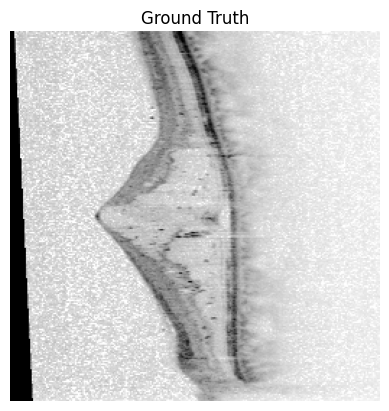

'\nmetric = evaluate.load("mean_iou")\nprint("SAM:")\nmetric = metric.compute(\n    predictions=[medsam_seg],\n    references=[ground_truth_mask],\n    num_labels=2,\n    ignore_index=255,\n    reduce_labels=False,\n)\nprint(metric)\n'

In [23]:
from kaggle_dme_utils import transforms, show_mask, get_bounding_box
from transformers import SamProcessor, SamModel
import torch
import numpy as np
from PIL import Image
import datasets
import matplotlib.pyplot as plt
import evaluate

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

base_models = ["facebook/sam-vit-base", "facebook/sam-vit-huge", "facebook/sam-vit-large", "wanglab/medsam-vit-base"]
base_model = base_models[3]
data_path = "/vol/data/2015_BOE_Chiu/preprocessed/"
preprocessed_dataset = "23-12-11 10.02.28"
checkpoint_path = "/vol/data/models/OCT/model_checkpoints/23-12-11 14.37.21chkpt.pt"


train_dataset = datasets.load_from_disk(data_path + preprocessed_dataset)["train"]
train_dataset.set_transform(transforms)

valid_dataset = datasets.load_from_disk(data_path + preprocessed_dataset)["test"]
valid_dataset.set_transform(transforms)

# let's take a random training example
idx = 5

# load image
train_image = train_dataset[idx]["pixel_values"]
valid_image = valid_dataset[idx]["pixel_values"]

image = train_image
dataset = train_dataset


# get box prompt based on ground truth segmentation map
ground_truth_mask = np.array(dataset[idx]["label"])
prompt = get_bounding_box(ground_truth_mask)
prompt = [0,0,254,254]

model_name = "facebook/sam-vit-base"
#model_name = "wanglab/medsam-vit-base"
processor = SamProcessor.from_pretrained(model_name)
model = SamModel.from_pretrained(model_name)
model.to("cuda")

states = torch.load(checkpoint_path)
model.load_state_dict(states, strict=False)

inputs = processor(image, input_boxes=[[prompt]], return_tensors="pt").to("cuda")
model.eval()
# forward pass
with torch.no_grad():
    outputs = model(**inputs, multimask_output=False)
# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
print(medsam_seg_prob)
medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)

plt.ion()
fig, axes = plt.subplots()

axes.imshow(np.array(image))
#show_mask(ground_truth_mask , axes)
show_mask(medsam_seg, axes, True)

#axes.title.set_text(f"Predicted mask Fine-tuned SAM")
axes.title.set_text(f"Ground Truth")
#axes.title.set_text(f"Raw")
#show_box(prompt, axes)
axes.axis("off")
plt.show()
"""
metric = evaluate.load("mean_iou")
print("SAM:")
metric = metric.compute(
    predictions=[medsam_seg],
    references=[ground_truth_mask],
    num_labels=2,
    ignore_index=255,
    reduce_labels=False,
)
print(metric)
"""

In [3]:
norm = plt.Normalize(vmin=0, vmax=255)

In [6]:
cm = plt.cm.hsv

In [24]:
t = cm(norm(image[:,:,0]))

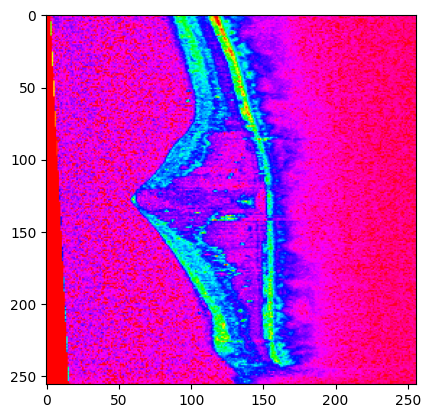

In [25]:
plt.imshow(t)

In [29]:
t[:,:,3]

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

(-0.5, 255.5, 255.5, -0.5)

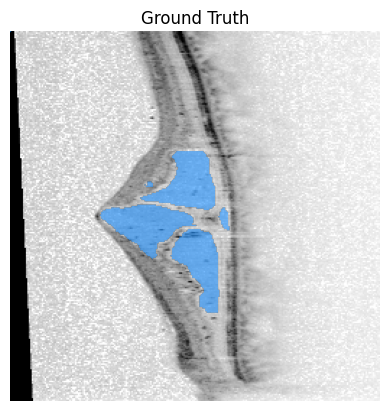

In [27]:
fig, axes = plt.subplots()

axes.imshow(np.array(image))
show_mask(ground_truth_mask , axes)
#show_mask(medsam_seg, axes, True)

#axes.title.set_text(f"Predicted mask Fine-tuned SAM")
axes.title.set_text(f"Ground Truth")
#axes.title.set_text(f"Raw")
#show_box(prompt, axes)
axes.axis("off")